In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
import numpy as np
import pandas as pd
from statsmodels.datasets import co2
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

In [6]:
# 加载数据
data = co2.load(as_pandas=True).data
data = data.resample('M').mean().ffill()

<AxesSubplot:title={'center':'co2'}>

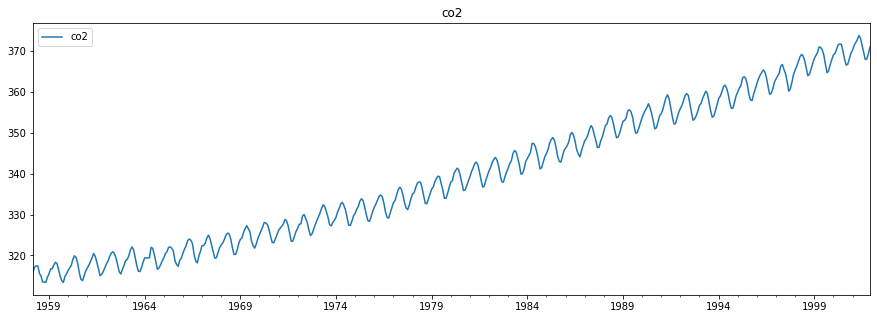

In [7]:
# 可视化
data.plot(figsize=(15, 5), color=next(color_cycle), title='co2')

In [10]:
# 单位根检验
res = adfuller(data)
print('p value:', res[1])
from arch.unitroot import ADF
adf = ADF(data)
# print(adf.pvalue)
print(adf.summary().as_text()) # 不能拒绝原假设，存在单位根

p value: 0.9989453312516823
   Augmented Dickey-Fuller Results   
Test Statistic                  2.285
P-value                         0.999
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


p value: 3.1329977323909814e-05
p value: 4.972109068702872e-10
p value: 0.0007785393674428758


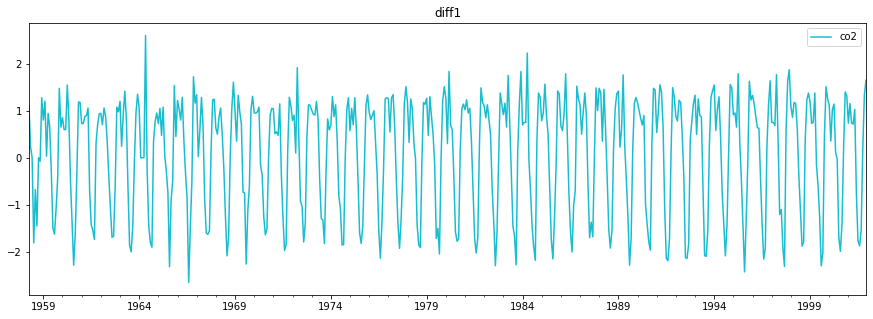

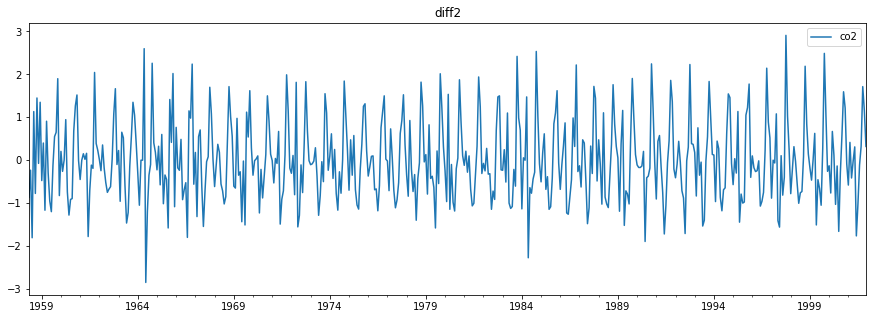

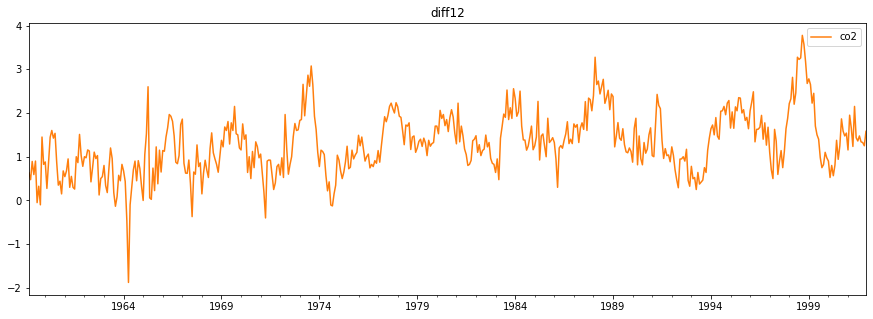

In [24]:
# 差分变为平稳序列
# # 一阶差分
data_diff1 = data.diff().dropna()
data_diff1.plot(figsize=(15, 5), color=next(color_cycle), title='diff1')
res = adfuller(data_diff1)
print('p value:', res[1])
# # 二阶差分
data_diff2 = data.diff().diff().dropna()
data_diff2.plot(figsize=(15, 5), color=next(color_cycle), title='diff2')
res = adfuller(data_diff2)
print('p value:', res[1])
# 季节差分
data_diff12 = data.diff(12).dropna()
data_diff12.plot(figsize=(15, 5), color=next(color_cycle), title='diff12')
res = adfuller(data_diff12)
print('p value:', res[1])

In [25]:
# 白噪声检测
# 小于0.5 拒绝原假设
from statsmodels.stats.diagnostic import acorr_ljungbox
res = acorr_ljungbox(data_diff1, lags=[6,12,24], return_df=True)  
print(res)
res = acorr_ljungbox(data_diff2, lags=[6,12,24], return_df=True)  
print(res)
res = acorr_ljungbox(data_diff12, lags=[6,12,24], return_df=True)  
print(res)

        lb_stat      lb_pvalue
6    697.802818  1.823510e-147
12  1708.430041   0.000000e+00
24  3407.004892   0.000000e+00
        lb_stat      lb_pvalue
6    143.313052   2.002478e-28
12   599.499481  1.355924e-120
24  1231.121590  5.675266e-245
        lb_stat      lb_pvalue
6   1249.517352  9.173589e-267
12  1534.064761   0.000000e+00
24  1547.525124   0.000000e+00


In [28]:
# 模型定阶
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

from statsmodels.tsa.stattools import arma_order_select_ic
bic_min_order = arma_order_select_ic(data_diff, max_ar=6, max_ma=4, ic='bic')['bic_min_order']
print(bic_min_order)

c:\zhangli\software\installer\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\zhangli\software\installer\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and st

(6, 3)


In [30]:
# 模型训练
from statsmodels.tsa.arima_model import ARMA
model = ARMA(data_diff12, order=bic_min_order).fit(disp=-1)
print(model.summary())

c:\zhangli\software\installer\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:                    co2   No. Observations:                  514
Model:                     ARMA(6, 3)   Log Likelihood                -236.970
Method:                       css-mle   S.D. of innovations              0.381
Date:                Wed, 30 Mar 2022   AIC                            495.940
Time:                        15:48:44   BIC                            542.605
Sample:                    03-31-1959   HQIC                           514.230
                         - 12-31-2001                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2966      0.108     12.035      0.000       1.085       1.508
ar.L1.co2      1.2555      0.050     24.932      0.000       1.157       1.354
ar.L2.co2      0.4545      0.070      6.510      0.0

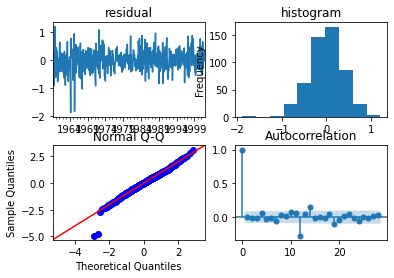

In [31]:
# 如果模型拟合充分，则残差序列服从零均值正态分布且完全随机无相关性。
# 所以还需要分析残差的正态性和无关性，以此检验模型拟合是否良好。
# 如果检验未通过，说明模型不合适或者参数没调好。
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3)

model.resid.plot(ax=axs[0][0])
axs[0][0].set_title('residual')

model.resid.plot(kind='hist', ax=axs[0][1])
axs[0][1].set_title('histogram')

sm.qqplot(model.resid, line='45', fit=True, ax=axs[1][0])
axs[1][0].set_title('Normal Q-Q')

plot_acf(model.resid, ax=axs[1][1])

plt.show()

# 上图可以看出残差基本服从正态分布，
# 但ACF图显示滞后12期时仍存在自相关性，所以模型还可优化。
# 猜想是否有可能模型定阶时限制了AR和MA的最大阶数，所以直接根据差分后样本数据的ACF图和PACF图定阶

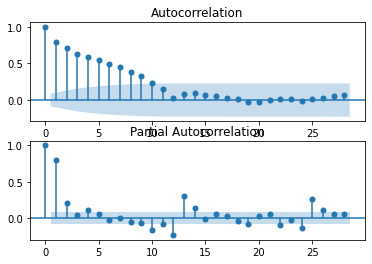

In [32]:
# PCF  APCF 进行模型的定阶
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2, 1)
plot_acf(data_diff, ax=axs[0])
plot_pacf(data_diff, ax=axs[1])
plt.show()

c:\zhangli\software\installer\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\zhangli\software\installer\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed t

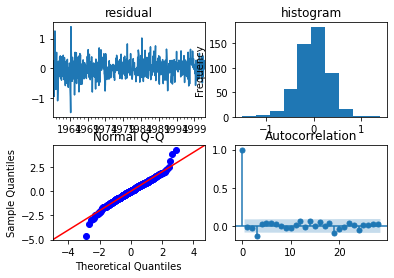

In [34]:
# 定阶后 重新进行训练，查看残差
model2 = ARMA(data_diff12, order=(2,11)).fit(disp=-1)

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3)

model2.resid.plot(ax=axs[0][0])
axs[0][0].set_title('residual')

model2.resid.plot(kind='hist', ax=axs[0][1])
axs[0][1].set_title('histogram')

sm.qqplot(model2.resid, line='45', fit=True, ax=axs[1][0])
axs[1][0].set_title('Normal Q-Q')

plot_acf(model2.resid, ax=axs[1][1])

plt.show()

<Figure size 864x288 with 0 Axes>

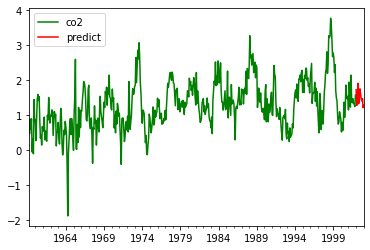

In [44]:
# 预测未来6期数据
# （注意ARMA模型预测时，预测期数超过MA模型最大阶数后，MA部分的预测值实际为序列均值不再变化，AR部分倒还会有持续变化但效果下降）。
preds = model2.predict(len(data_diff12), len(data_diff12)+12)

# 也可只取未来预测值
# fcast = model2.forecast(6)

plt.figure(figsize=(12, 4))
data_diff.plot(color='g', label='data_diff')
preds.plot(color='r', label='predict')
plt.legend()
plt.show()

In [45]:
# 差分还原
# 把曾经减去的项再加回来
df1 = pd.DataFrame(data)
df2 = pd.DataFrame(preds, columns=['predict'])
df = pd.concat([df1, df2], axis=1)
df['result'] = df['predict'] + df['co2'].shift(12)
df

,co2,predict,result
1958-03-31,316.100000,NaN,NaN
1958-04-30,317.200000,NaN,NaN
1958-05-31,317.433333,NaN,NaN
1958-06-30,317.433333,NaN,NaN
1958-07-31,315.625000,NaN,NaN
...,...,...,...
2002-09-30,NaN,1.466270,369.346270
2002-10-31,NaN,1.412419,369.462419
2002-11-30,NaN,1.474730,370.849730
2002-12-31,NaN,1.217522,372.237522
